# 1. Import the Necessary Packages

In [1]:
import os
import pickle

import gym
import random
import torch
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# 2. Instatiate the Environment

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: {}'.format(env.observation_space.shape))
print('Number of actions: {}'.format(env.action_space.n))

State shape: (8,)
Number of actions: 4


/Users/jastills/personal_projects/deep-reinforcement-learning/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# 3. Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed):
        
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        #fc1 8 -> 64
        self.fc1 = nn.Linear(state_size, 64)
        
        #relu1
        self.relu1 = nn.ReLU()
        
        #fc2 64 -> 64
        self.fc2 = nn.Linear(64, 64)
        
        #relu2
        self.relu2 = nn.ReLU()
        
        #fc3 64 -> action_size
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        
        #input state: [bsz, 8]
        
        #fc1 8 -> 64
        x = self.fc1(state)
        
        #relu1
        x = self.relu1(x)
        
        #fc2 64 -> 64
        x = self.fc2(x)
        
        #relu2
        x = self.relu2(x)
        
        #fc3 64 -> action_size
        x = self.fc3(x)
        
        return x

# 4. Define Agent

In [5]:
import random
import torch.optim as optim

BUFFER_SIZE = int(100000) # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3                # for soft update of target parameters
LR = 0.0005               # learning rate
UPDATE_EVERY = 4          # how often to update the network

class DQNAgent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # initialize Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # initialize time step
        self.t_step = 0
    
    
    def step(self, state, action, reward, next_state, done):
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    
    def act(self, state, eps=0.):
        # single state to state tensor (batch size = 1)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # set eval mode for local QN 
        self.qnetwork_local.eval()
        
        # predict state value with local QN
        with torch.no_grad(): # no need to save the gradient value
            action_values = self.qnetwork_local(state)
        
        # set the mode of local QN back to train
        self.qnetwork_local.train()
        
        # e-greedy action selection
        # return greedy action if prob > eps
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        
        # return random action if prob <= eps
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def learn(self, experiences, gamma):
        
        # unpack epxeriences
        states, actions, rewards, next_states, dones = experiences
        
        # define loss function: MSELoss
        loss_function = torch.nn.MSELoss()
        
        # get max predicted Q values from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q targets from current states
        Q_targets = rewards + gamma * Q_targets_next * (1-dones)
        
        # get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # compute loss
        loss = loss_function(Q_expected, Q_targets)
        
        # minimise the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    
    def soft_update(self, local_model, target_model, tau):
        # Q_target = TAU * local_model + (1-TAU) * target_model
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

In [6]:
from collections import deque, namedtuple
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    
    # initialize ReplayBuffer
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", 
                                                                "action", 
                                                                "reward", 
                                                                "next_state", 
                                                                "done"])
        self.seed = random.seed(seed)
    
    # add a new experience to memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # randomly sample a batch of experiences from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    # return the size of the internal memory
    def __len__(self):
        return len(self.memory)

# 5. Train the agent

In [7]:
from collections import deque

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, fname="dqn"):
    
    output_path = "outputs/{}".format(fname)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start # initialize epsilon
    save_score_threshold = 200
    
    # for every episode..
    for i_episode in range(1, n_episodes + 1):
        
        # reset state
        state = env.reset()
        
        # reset score to 0
        score = 0
        
        # for every time step until max_t
        for t in range(max_t):
            
            # get action based on e-greedy policy
            action = agent.act(state, eps)
            
            # execute the chosen action
            next_state, reward, done, _ = env.step(action)
            
            # update the network with experience replay
            agent.step(state, action, reward, next_state, done)
            
            # set next_state as the new state
            state = next_state
            
            # add reward to the score
            score += reward
            
            # if the agent has reached the terminal state, break the loop
            if done:
                break
        
        # append the episode score to the deque
        scores_window.append(score)
        
        # append the episode score to the list
        scores.append(score)
        
        # decrease episilon
        eps = max(eps_end, eps_decay * eps)
        
        # display metrics
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # save model if the latest average score is higher than 200.0
        if np.mean(scores_window) >= save_score_threshold:
            print('\nEnvironment solved in {:d} episodes! \tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), '{}/cp{:04d}.pth'.format(output_path, i_episode-100))
            save_score_threshold += 5
            
    with open(os.path.join(output_path, "score.pkl"), "wb") as f:
        pickle.dump(scores, f)


In [8]:
# fname = "dqn"
# agent = DQNAgent(state_size=8, action_size=4, seed=0)
# dqn(agent, fname=fname)

# Double DQN Agent

In [9]:
import random
import torch.optim as optim

BUFFER_SIZE = int(100000) # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3                # for soft update of target parameters
LR = 0.0005               # learning rate
UPDATE_EVERY = 4          # how often to update the network

class DDQNAgent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # initialize Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # initialize time step
        self.t_step = 0
    
    
    def step(self, state, action, reward, next_state, done):
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    
    def act(self, state, eps=0.):
        # single state to state tensor (batch size = 1)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # set eval mode for local QN 
        self.qnetwork_local.eval()
        
        # predict state value with local QN
        with torch.no_grad(): # no need to save the gradient value
            action_values = self.qnetwork_local(state)
        
        # set the mode of local QN back to train
        self.qnetwork_local.train()
        
        # e-greedy action selection
        # return greedy action if prob > eps
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        
        # return random action if prob <= eps
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def learn(self, experiences, gamma):
        
        # unpack epxeriences
        states, actions, rewards, next_states, dones = experiences
        
        # define loss function: MSELoss
        loss_function = torch.nn.MSELoss()
        
        best_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, best_actions)
        
        # compute Q targets from current states
        Q_targets = rewards + gamma * Q_targets_next * (1-dones)
        
        # get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # compute loss
        loss = loss_function(Q_expected, Q_targets)
        
        # minimise the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    
    def soft_update(self, local_model, target_model, tau):
        # Q_target = TAU * local_model + (1-TAU) * target_model
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

In [10]:
# env = gym.make('LunarLander-v2')
# env.seed(0)
# agent = DDQNAgent(state_size=8, action_size=4, seed=0)
# dqn(agent, fname='ddqn')

# Prioritize Experience Replay

In [11]:
import random
import torch.optim as optim

BUFFER_SIZE = int(100000) # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3                # for soft update of target parameters
LR = 0.0005               # learning rate
UPDATE_EVERY = 4          # how often to update the network


class PrioritizedReplayBuffer(object):
    """
    https://github.com/higgsfield/RL-Adventure/blob/master/4.prioritized%20dqn.ipynb
    """
    def __init__(self, buffer_size, batch_size, prob_alpha=0.6, prob_beta=0.5):
        self.prob_alpha = prob_alpha
        self.prob_beta = prob_beta
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((buffer_size, ), dtype=np.float32) # long array
        self.experience = namedtuple("Experience", field_names=["state", 
                                                                "action", 
                                                                "reward", 
                                                                "next_state",
                                                                "done"])
        
    def add(self, state, action, reward, next_state, done):
        
        # if self.buffer is empty return 1.0, else max
        max_priority = self.priorities.max() if self.buffer else 1.0
        exp = self.experience(state, action, reward, next_state, done)
        
        # if buffer has rooms left
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(exp)
        else:
            self.buffer[self.pos] = exp
        
        # assign max priority
        self.priorities[self.pos] = max_priority
        
        # update index
        self.pos = (self.pos + 1) % self.buffer_size 
        
    def sample(self, completion):
        
        beta = self.prob_beta + (1-self.prob_beta) * completion
        
        # if buffer is maxed out..
        if len(self.buffer) == self.buffer_size:
            # all priorities are the same as self.priorities
            priorities = self.priorities
        else:
            # all priorities are up to self.pos cuz it's not full yet
            priorities = self.priorities[:self.pos]
            
        # $ P(i) = (p_i^\alpha) / \Sigma_k p_k^\alpha $
        probabilities_a = priorities ** self.prob_alpha
        sum_probabilties_a = probabilities_a.sum()
        P_i = probabilities_a / sum_probabilties_a
        
        sampled_indices = np.random.choice(len(self.buffer), self.batch_size, p=P_i)
        experiences = [self.buffer[idx] for idx in sampled_indices]
        
        # $ w_i = ( 1/N * 1/P(i) ) ** \beta $
        # $ w_i = ( N * P(i) ** (-1 * \beta) ) $
        N = len(self.buffer)
        weights = ( N * P_i[sampled_indices] ) ** (-1 * beta)
        
        #  For stability reasons, we always normalize weights by 1/ maxi wi so
        #  that they only scale the update downwards.
        weights = weights / weights.max()
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float().to(device)
        weights = torch.from_numpy(np.vstack(weights)).float()
        
        return states, actions, rewards, next_states, dones, sampled_indices, weights
        
    def update_priorities(self, batch_indicies, batch_priorities):
        for idx, priority in zip(batch_indicies, batch_priorities):
            self.priorities[idx] = priority
        
    def __len__(self):
        return len(self.buffer)


class DDQNPERAgent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # initialize Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # replay memory
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # initialize time step
        self.t_step = 0
    
    
    def step(self, state, action, reward, next_state, done, completion):
        
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(completion)
                self.learn(experiences, GAMMA)
    
    def act(self, state, eps=0.):
        # single state to state tensor (batch size = 1)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # set eval mode for local QN 
        self.qnetwork_local.eval()
        
        # predict state value with local QN
        with torch.no_grad(): # no need to save the gradient value
            action_values = self.qnetwork_local(state)
        
        # set the mode of local QN back to train
        self.qnetwork_local.train()
        
        # e-greedy action selection
        # return greedy action if prob > eps
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        
        # return random action if prob <= eps
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def learn(self, experiences, gamma, p_eps = 1e-5):
        
        # unpack epxeriences
        states, actions, rewards, next_states, dones, sampled_indicies, weights = experiences
        
        
        best_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, best_actions)
        
        # compute Q targets from current states
        Q_targets = rewards + gamma * Q_targets_next * (1-dones)
        
        # get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        TD_Error = Q_targets - Q_expected
        new_priorities = TD_Error.abs().detach().numpy() + p_eps
        
        loss = (TD_Error.pow(2) * weights).mean()
        
        
        
        # minimise the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.memory.update_priorities(sampled_indicies, new_priorities)
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    
    def soft_update(self, local_model, target_model, tau):
        # Q_target = TAU * local_model + (1-TAU) * target_model
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

In [12]:
from collections import deque

def ddqn_with_per(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, fname="dqn"):
    
    output_path = "outputs/{}".format(fname)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start # initialize epsilon
    save_score_threshold = 200
    
    # for every episode..
    for i_episode in range(1, n_episodes + 1):
        
        # episode completion
        completion = i_episode / n_episodes
        
        # reset state
        state = env.reset()
        
        # reset score to 0
        score = 0
        
        # for every time step until max_t
        for t in range(max_t):
            
            # get action based on e-greedy policy
            action = agent.act(state, eps)
            
            # execute the chosen action
            next_state, reward, done, _ = env.step(action)
            
            # update the network with experience replay
            agent.step(state, action, reward, next_state, done, completion)
            
            # set next_state as the new state
            state = next_state
            
            # add reward to the score
            score += reward
            
            # if the agent has reached the terminal state, break the loop
            if done:
                break
        
        # append the episode score to the deque
        scores_window.append(score)
        
        # append the episode score to the list
        scores.append(score)
        
        # decrease episilon
        eps = max(eps_end, eps_decay * eps)
        
        # display metrics
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # save model if the latest average score is higher than 200.0
        if np.mean(scores_window) >= save_score_threshold:
            print('\nEnvironment solved in {:d} episodes! \tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), '{}/cp{:04d}.pth'.format(output_path, i_episode-100))
            save_score_threshold += 5
    
    with open(os.path.join(output_path, "score.pkl"), "wb") as f:
        pickle.dump(scores, f)

In [13]:
# env = gym.make('LunarLander-v2')
# env.seed(0)
# agent = DDQNPERAgent(state_size=8, action_size=4, seed=0)
# ddqn_with_per(agent, fname='ddqn_per')

# Dueling Network

In [14]:
class DuelingNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed):
        
        super(DuelingNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        
        #fc1 8 -> 64
        self.fc1 = nn.Linear(state_size, 64)
        
        #relu1
        self.relu1 = nn.ReLU()
        
        #fc2 64 -> 64
        self.fc2 = nn.Linear(64, 64)
        
        #relu2
        self.relu2 = nn.ReLU()
        
        #fc3 64 -> state_value = 1
        self.fc3_to_state_value = nn.Linear(64, 1)
        
        #fc3 64 -> action_value
        self.fc3_to_action_value = nn.Linear(64, self.action_size)
        
    def forward(self, state):
        
        #input state: [bsz, 8]
        
        #fc1 8 -> 64
        x = self.fc1(state)
        
        #relu1
        x = self.relu1(x)
        
        #fc2 64 -> 64
        x = self.fc2(x)
        
        #relu2
        x = self.relu2(x)
        
        #fc3 64 -> state_value
        v_x = self.fc3_to_state_value(x)
        
        #fc3 64 -> action_value
        a_x = self.fc3_to_action_value(x)
        
        #average operator
        average_operator = (1 / self.action_size) * a_x
        
        x = v_x + ( a_x - average_operator ) 
        
        return x

In [15]:
class DNPERAgent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # initialize DuelingNetwork
        self.qnetwork_local = DuelingNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # replay memory
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # initialize time step
        self.t_step = 0
    
    
    def step(self, state, action, reward, next_state, done, completion):
        
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(completion)
                self.learn(experiences, GAMMA)
    
    def act(self, state, eps=0.):
        # single state to state tensor (batch size = 1)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # set eval mode for local QN 
        self.qnetwork_local.eval()
        
        # predict state value with local QN
        with torch.no_grad(): # no need to save the gradient value
            action_values = self.qnetwork_local(state)
        
        # set the mode of local QN back to train
        self.qnetwork_local.train()
        
        # e-greedy action selection
        # return greedy action if prob > eps
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        
        # return random action if prob <= eps
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def learn(self, experiences, gamma, p_eps = 1e-5):
        
        # unpack epxeriences
        states, actions, rewards, next_states, dones, sampled_indicies, weights = experiences
        
        
        best_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, best_actions)
        
        # compute Q targets from current states
        Q_targets = rewards + gamma * Q_targets_next * (1-dones)
        
        # get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        TD_Error = Q_targets - Q_expected
        new_priorities = TD_Error.abs().detach().numpy() + p_eps
        
        loss = (TD_Error.pow(2) * weights).mean()
        
        
        
        # minimise the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.memory.update_priorities(sampled_indicies, new_priorities)
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    
    def soft_update(self, local_model, target_model, tau):
        # Q_target = TAU * local_model + (1-TAU) * target_model
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

In [16]:
# env = gym.make('LunarLander-v2')
# env.seed(0)
# agent = DNPERAgent(state_size=8, action_size=4, seed=0)
# ddqn_with_per(agent, fname='dn_per')

In [17]:
with open("outputs/dqn/score.pkl", "rb") as f:
    dqn_scores = pickle.load(f)
with open("outputs/ddqn/score.pkl", "rb") as f:
    ddqn_scores = pickle.load(f)
with open("outputs/ddqn_per/score.pkl", "rb") as f:
    ddqn_per_scores = pickle.load(f)
with open("outputs/dn_per/score.pkl", "rb") as f:
    dn_per_scores = pickle.load(f)

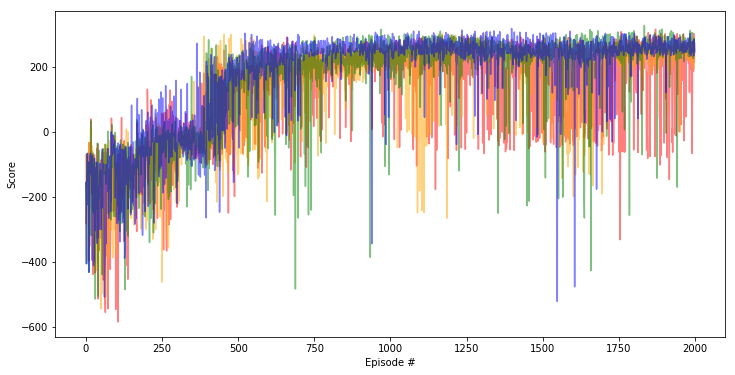

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(dqn_scores)), dqn_scores, color='red', alpha=0.5)
ax.plot(np.arange(len(ddqn_scores)), ddqn_scores, color='orange', alpha=0.5)
ax.plot(np.arange(len(ddqn_per_scores)), ddqn_per_scores, color='green', alpha=0.5)
ax.plot(np.arange(len(dn_per_scores)), dn_per_scores, color='blue', alpha=0.5)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

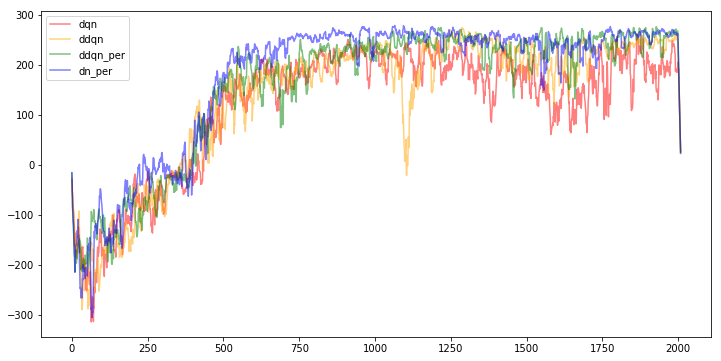

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

window = 10

avg_mask = np.ones(window) / window
dqn_mov = np.convolve(dqn_scores, avg_mask)
ddqn_mov = np.convolve(ddqn_scores, avg_mask)
ddqn_per_mov = np.convolve(ddqn_per_scores, avg_mask)
dn_per_mov = np.convolve(dn_per_scores, avg_mask)

ax.plot(np.arange(len(dqn_mov)), dqn_mov, color='red', alpha=0.5, label='dqn')
ax.plot(np.arange(len(ddqn_mov)), ddqn_mov, color='orange', alpha=0.5, label='ddqn')
ax.plot(np.arange(len(ddqn_per_mov)), ddqn_per_mov, color='green', alpha=0.5, label='ddqn_per')
ax.plot(np.arange(len(dn_per_mov)), dn_per_mov, color='blue', alpha=0.5, label='dn_per')

ax.legend()

plt.show()

In [20]:
seed = 5

In [21]:
import time

def test_run(seed):
    models = ['outputs/dqn/cp0873.pth', 
              'outputs/ddqn/cp1238.pth', 
              'outputs/ddqn_per/cp1244.pth', 
              'outputs/dn_per/cp1009.pth']

    for model in models:
        total_reward = 0
        
        env = gym.make('LunarLander-v2')
        
        agent_type = model.split("/")[1]
        
        if agent_type == 'dqn':
            agent = DQNAgent(8, 4, 0)
        elif agent_type == 'ddqn':
            agent = DDQNAgent(8, 4, 0)
        elif agent_type == 'ddqn_per':
            agent = DDQNPERAgent(8, 4, 0)    
        elif agent_type == 'dn_per':
            agent = DNPERAgent(8, 4, 0)
        else:
            raise ValueError
            
        agent.qnetwork_local.load_state_dict(torch.load(model))
            
        for i in range(1):

            env.seed(seed)
            state = env.reset()
            time.sleep(3)
            for j in range(500):
                action = agent.act(state)
                env.render()
                state, reward, done, _ = env.step(action)
                total_reward += reward
                if done:
                    time.sleep(1)
                    break 

        print(model, total_reward)
        env.close()
        


In [22]:
test_run(6) # v

outputs/dqn/cp0873.pth 226.65568476166658
outputs/ddqn/cp1238.pth 285.7782801477665
outputs/ddqn_per/cp1244.pth 288.2310893633825
outputs/dn_per/cp1009.pth 250.26832432253772


In [23]:
test_run(42)

outputs/dqn/cp0873.pth 281.55481696886795
outputs/ddqn/cp1238.pth 277.3025306295631
outputs/ddqn_per/cp1244.pth 275.6694892153752
outputs/dn_per/cp1009.pth 287.1865665591303


In [24]:
test_run(542)

outputs/dqn/cp0873.pth 216.0104164685676
outputs/ddqn/cp1238.pth 299.0463971784982
outputs/ddqn_per/cp1244.pth 278.7571920882258
outputs/dn_per/cp1009.pth 288.5777973702776


In [ ]:
test_run(4444)

outputs/dqn/cp0873.pth 218.69102712099766
outputs/ddqn/cp1238.pth 241.16645785088184
outputs/ddqn_per/cp1244.pth 228.93702844818137
outputs/dn_per/cp1009.pth 241.91770904758806


In [ ]:
test_run(1500) # v

outputs/dqn/cp0873.pth 191.00104222498695
outputs/ddqn/cp1238.pth 245.15011716973393
outputs/ddqn_per/cp1244.pth 235.6764009679421
